# Classification Models

## Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nbimporter

import TrainTestEvalSplit as split

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#Classification Metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from yellowbrick.classifier import ClassPredictionError

import pickle

from sklearn.model_selection import KFold
from sklearn.utils import check_X_y

## Import File

In [2]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

full_df.head()

,Date,Hour,weekday,is_weekend,Sensor,CrowdednessCount,Lon_4.8971927,Lon_4.8973336,Lon_4.8977166,Lon_4.8979076,...,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,Nieuwmarkt score,Nieuwezijds Kolk score,Dam score,Spui score
0,2018-03-11,100,6.0,1.0,GAWW-04,886,0,0,0,1,...,1.0,6.123234e-17,0.188227,0.982126,0.258819,0.965926,0.000000,0.000000,102.996844,0.000000
1,2018-03-11,2100,6.0,1.0,GAWW-07,1603,0,0,0,0,...,1.0,6.123234e-17,0.188227,0.982126,-0.707107,0.707107,346.998829,198.995171,1266.930956,133.989730
2,2018-03-11,2100,6.0,1.0,GAWW-08,21,1,0,0,0,...,1.0,6.123234e-17,0.188227,0.982126,-0.707107,0.707107,346.997145,198.996668,1266.966573,133.995346
3,2018-03-11,2100,6.0,1.0,GAWW-09,88,0,0,0,0,...,1.0,6.123234e-17,0.188227,0.982126,-0.707107,0.707107,346.997014,198.997601,1266.952991,133.991938
4,2018-03-11,2100,6.0,1.0,GAWW-10,49,0,0,0,0,...,1.0,6.123234e-17,0.188227,0.982126,-0.707107,0.707107,346.998943,198.995907,1266.951383,133.993174


## Train/Test/Eval

In [3]:
size = 0.9
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [4]:
full_df = split.clasCrowdednessCounts(full_df)

In [6]:
x_train, y_train, x_test, y_test, train_dates = split.trainTestSplit(full_df, size)

## Models

### Baseline
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

#### Training

In [7]:
base = DummyClassifier(strategy="stratified", random_state=42)

In [8]:
labels = [1, 2, 3, 4]

mean_acc = 0

mean_precision = 0
mean_recall = 0
mean_f1_score = 0

for train_index, val_index in kf.split(train_dates):
    
    x_train_con, y_train_con = check_X_y(X=x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
                                        y=y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    base.fit(x_train_con,y_train_con)
    
    x_val_con, y_val_con = check_X_y(X=x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
                                    y=y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"])
    
    y_pred_base = base.predict(x_val_con)
    
    mean_acc += accuracy_score(y_val_con, y_pred_base)

    mean_precision += precision_score(y_val_con, y_pred_base, average=None)
    mean_recall += recall_score(y_val_con, y_pred_base, average=None)
    mean_f1_score += f1_score(y_val_con, y_pred_base, average=None)

mean_acc = round(((mean_acc / 10) * 100),2)
mean_precision = (mean_precision / 10) * 100
mean_recall = (mean_recall / 10) * 100
mean_f1_score = (mean_f1_score / 10) * 100

print("Mean Accuracy Score: ", mean_acc, "\n")

for i in range(len(labels)):
    print("For label {0}".format(labels[i]))
    print("Mean Precision Score: ", round(mean_precision[i], 2))
    print("Mean Recall Score: ", round(mean_recall[i], 2))
    print("Mean F1 Score: ", round(mean_f1_score[i], 2), "\n")

Mean Accuracy Score:  24.87 

For label 1
Mean Precision Score:  24.74
Mean Recall Score:  24.46
Mean F1 Score:  24.57 

For label 2
Mean Precision Score:  25.08
Mean Recall Score:  25.49
Mean F1 Score:  25.27 

For label 3
Mean Precision Score:  24.93
Mean Recall Score:  24.27
Mean F1 Score:  24.52 

For label 4
Mean Precision Score:  24.93
Mean Recall Score:  25.43
Mean F1 Score:  25.05 



#### Test

Accuracy Score:  0.2496276437295204
              precision    recall  f1-score   support

           1       0.25      0.25      0.25      2525
           2       0.25      0.26      0.25      2562
           3       0.24      0.25      0.25      2539
           4       0.25      0.24      0.25      2445

   micro avg       0.25      0.25      0.25     10071
   macro avg       0.25      0.25      0.25     10071
weighted avg       0.25      0.25      0.25     10071



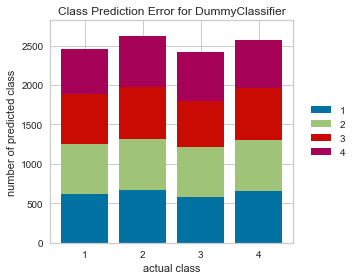

In [11]:
y_pred_test_base = base.predict(x_test)
print("Accuracy Score: ", accuracy_score(y_test, y_pred_test_base))
print(classification_report(y_test, y_pred_test_base))

visualizer = ClassPredictionError(
    base
)

visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])
visualizer.score(x_test, y_test)
g = visualizer.poof()

### Random Forrest Classifier 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

#### Training

In [12]:
rfc = RandomForestClassifier(n_estimators=300, criterion="entropy", n_jobs=50, random_state=42, 
                                  class_weight="balanced", oob_score="True")

In [13]:
labels = [1, 2, 3, 4]

mean_acc = 0

mean_precision = 0
mean_recall = 0
mean_f1_score = 0

for train_index, val_index in kf.split(train_dates):
    
    x_train_con, y_train_con = check_X_y(X=x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
                                        y=y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    rfc.fit(x_train_con,y_train_con)
    
    x_val_con, y_val_con = check_X_y(X=x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
                                    y=y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"])
    
    y_pred_base = rfc.predict(x_val_con)
    
    mean_acc += accuracy_score(y_val_con, y_pred_base)

    mean_precision += precision_score(y_val_con, y_pred_base, average=None)
    mean_recall += recall_score(y_val_con, y_pred_base, average=None)
    mean_f1_score += f1_score(y_val_con, y_pred_base, average=None)

mean_acc = round(((mean_acc / 10) * 100),2)
mean_precision = (mean_precision / 10) * 100
mean_recall = (mean_recall / 10) * 100
mean_f1_score = (mean_f1_score / 10) * 100

print("Mean Accuracy Score: ", mean_acc, "\n")

for i in range(len(labels)):
    print("For label {0}".format(labels[i]))
    print("Mean Precision Score: ", round(mean_precision[i], 2))
    print("Mean Recall Score: ", round(mean_recall[i], 2))
    print("Mean F1 Score: ", round(mean_f1_score[i], 2), "\n")

Mean Accuracy Score:  87.04 

For label 1
Mean Precision Score:  87.26
Mean Recall Score:  83.83
Mean F1 Score:  85.49 

For label 2
Mean Precision Score:  83.64
Mean Recall Score:  82.2
Mean F1 Score:  82.91 

For label 3
Mean Precision Score:  88.13
Mean Recall Score:  88.38
Mean F1 Score:  88.24 

For label 4
Mean Precision Score:  88.84
Mean Recall Score:  93.82
Mean F1 Score:  91.23 



#### Test

Accuracy Score:  0.8671432826928805
              precision    recall  f1-score   support

           1       0.86      0.84      0.85      2525
           2       0.83      0.81      0.82      2562
           3       0.88      0.89      0.89      2539
           4       0.90      0.94      0.92      2445

   micro avg       0.87      0.87      0.87     10071
   macro avg       0.87      0.87      0.87     10071
weighted avg       0.87      0.87      0.87     10071



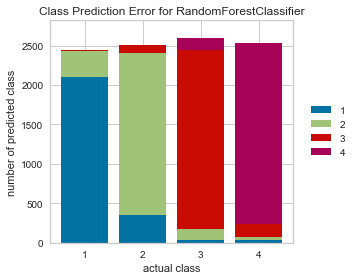

In [14]:
y_pred_test_rfc = rfc.predict(x_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred_test_rfc))
print(classification_report(y_test, y_pred_test_rfc))

visualizer = ClassPredictionError(
    rfc
)

visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])
visualizer.score(x_test, y_test)
g = visualizer.poof()

#### Save Model to File

In [50]:
filename = "../../../Data_thesis/Models/rfc_model.sav"

pickle.dump(rfc, open(filename, 'wb'))

### XGBoost 
Implement [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

#### Training

In [15]:
xgb = xgb.XGBClassifier(random_state=42, n_estimators=300, max_depth=12, 
                              learning_rate=0.1, booster="gbtree", n_jobs=50)

In [16]:
labels = [1, 2, 3, 4]

mean_acc = 0

mean_precision = 0
mean_recall = 0
mean_f1_score = 0

for train_index, val_index in kf.split(train_dates):
    
    xgb.fit(x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
            y_train[y_train["Date"].isin(train_dates[train_index])]["CrowdednessCount"])
    
    y_pred_base = xgb.predict(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    
    mean_acc += accuracy_score(y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"], y_pred_base)

    mean_precision += precision_score(y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"], y_pred_base, average=None)
    mean_recall += recall_score(y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"], y_pred_base, average=None)
    mean_f1_score += f1_score(y_train[y_train["Date"].isin(train_dates[val_index])]["CrowdednessCount"], y_pred_base, average=None)

mean_acc = round(((mean_acc / 10) * 100),2)
mean_precision = (mean_precision / 10) * 100
mean_recall = (mean_recall / 10) * 100
mean_f1_score = (mean_f1_score / 10) * 100

print("Mean Accuracy Score: ", mean_acc, "\n")

for i in range(len(labels)):
    print("For label {0}".format(labels[i]))
    print("Mean Precision Score: ", round(mean_precision[i], 2))
    print("Mean Recall Score: ", round(mean_recall[i], 2))
    print("Mean F1 Score: ", round(mean_f1_score[i], 2), "\n")

Mean Accuracy Score:  87.05 

For label 1
Mean Precision Score:  86.74
Mean Recall Score:  84.67
Mean F1 Score:  85.67 

For label 2
Mean Precision Score:  83.52
Mean Recall Score:  82.47
Mean F1 Score:  82.98 

For label 3
Mean Precision Score:  87.97
Mean Recall Score:  88.24
Mean F1 Score:  88.09 

For label 4
Mean Precision Score:  89.7
Mean Recall Score:  92.83
Mean F1 Score:  91.22 



#### Test

Accuracy Score:  0.8647602025618112
              precision    recall  f1-score   support

           1       0.85      0.84      0.85      2525
           2       0.82      0.80      0.81      2562
           3       0.88      0.89      0.88      2539
           4       0.91      0.92      0.92      2445

   micro avg       0.86      0.86      0.86     10071
   macro avg       0.86      0.87      0.86     10071
weighted avg       0.86      0.86      0.86     10071



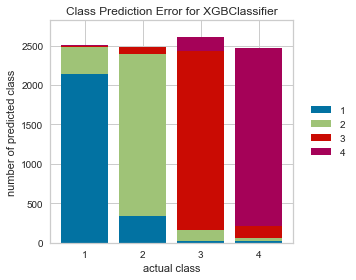

In [17]:
y_pred_test_xgb = xgb.predict(x_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred_test_xgb))
print(classification_report(y_test, y_pred_test_xgb))

visualizer = ClassPredictionError(
    xgb
)

visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])
visualizer.score(x_test, y_test)
g = visualizer.poof()

#### Save Model to File

In [53]:
filename = "../../../Data_thesis/Models/xgbc_model.sav"

pickle.dump(xgb, open(filename, 'wb'))